In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab/CleanedData/'


Mounted at /content/drive


In [ ]:
!pip install -q fasttext

     |████████████████████████████████| 68 kB 5.0 MB/s 


In [ ]:
#Source: https://www.kaggle.com/jungealexander/word2vec-and-random-forest-classification

import fasttext
import pandas as pd
import pickle
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn import preprocessing

file = '/content/drive/MyDrive/Colab/AI4Bharat/indicnlp.v1.hi.bin'
#path = '/content/drive/MyDrive/Colab/Embeddings+All/'
#analysis_path = '/content/drive/MyDrive/Colab/Embeddings+All/Analysis/'
#read the train and test files in majority dataset and insert the embeddings in the files
train_df = pd.read_csv('/content/drive/MyDrive/Colab/CleanedData/RankedClassification/train_updated.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab/CleanedData/RankedClassification/test_updated.csv')

model = fasttext.load_model(file)

def vectorise(key):
    try:
        return model.get_word_vector(key)
    except:
	      return [0]*300 #dimensions

X_train = train_df[['word']]
y_train = train_df['label']

X_test = test_df[['word']]
y_test = test_df['label']

#extract normalised embeddings
df = X_train.copy()
df['vector'] = X_train['word'].apply(vectorise)
X_train_vector = pd.DataFrame(df['vector'].values.tolist())
scaler = preprocessing.MinMaxScaler().fit(X_train_vector)
X_train_vector =  pd.DataFrame(scaler.transform(X_train_vector))
train_df.index = X_train_vector.index

df = X_test.copy()
df['vector'] = X_test['word'].apply(vectorise)
X_test_vector = pd.DataFrame(df['vector'].values.tolist())
scaler = preprocessing.MinMaxScaler().fit(X_test_vector)
X_test_vector = pd.DataFrame(scaler.transform(X_test_vector))
test_df.index = X_test_vector.index

columns = ['length', 'n_synsets', 'n_synonyms', 'n_consonants', 'n_vowels', 'n_hypernyms', 'n_hyponyms', 'n_consonantconjuncts', 'n_syllables', 'frequency']

for column in columns:
    X_train_vector[column] = train_df[[column]]
    X_test_vector[column] = test_df[[column]]
#print(X_train_vector.columns, X_test_vector.columns)

#X_train_vector.to_csv(path + "trainembeddingsfreq.csv")
#X_test_vector.to_csv(path + "testembeddingsfreq.csv")


#classify(path, X_train_vector, y_train)
#test(X_test_vector, y_test, path, analysis_path, 'test')


In [ ]:
!pip install torch==1.9.0+cpu torchvision==0.10.0+cpu torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 175.5 MB 9.3 kB/s 
     |████████████████████████████████| 15.7 MB 105 kB/s 
     |████████████████████████████████| 1.9 MB 11.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torc

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.9.0+cpu


In [ ]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(X_train_vector.values).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=20,
    shuffle=False, num_workers=1)

#features = ["length","n_synsets","n_synonyms","n_consonants","n_vowels","n_hypernyms","n_hyponyms","n_consonantconjuncts","n_syllables","frequency"]
features = range(1, 311)
label = "label"
cwi_classes = [1,0]

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(X_test_vector.values).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=20,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
# Define a neural network

# Number of hidden layer nodes
hl = 100

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(len(features), hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, len(cwi_classes))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

# Create a model instance from the network
model = NeuralNet()
print(model)

NeuralNet(
  (fc1): Linear(in_features=310, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)


In [ ]:
def train(model, data_loader, optimizer):
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()

        # backpropagate
        loss.backward()
        optimizer.step()

    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        target_true = 0
        predicted_true = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += loss_criteria(out, target).item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()

           
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f})%\n'.format(
        avg_loss, correct, len(data_loader.dataset),100. * correct / len(data_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 0.405266
Validation set: Average loss: 3.612324, Accuracy: 1280/2190 (58)%

Epoch: 2
Training set: Average loss: 1.039616
Validation set: Average loss: 0.693147, Accuracy: 1280/2190 (58)%

Epoch: 3
Training set: Average loss: 0.693147
Validation set: Average loss: 0.693147, Accuracy: 1280/2190 (58)%

Epoch: 4
Training set: Average loss: 0.693147
Validation set: Average loss: 0.693147, Accuracy: 1280/2190 (58)%

Epoch: 5
Training set: Average loss: 0.693147
Validation set: Average loss: 0.693147, Accuracy: 1280/2190 (58)%

Epoch: 6
Training set: Average loss: 0.693147
Validation set: Average loss: 0.693147, Accuracy: 1280/2190 (58)%

Epoch: 7
Training set: Average loss: 0.693147
Validation set: Average loss: 0.693147, Accuracy: 1280/2190 (58)%

Epoch: 8
Training set: Average loss: 0.693147
Validation set: Average loss: 0.693147, Accuracy: 1280/2190 (58)%

Epoch: 9
Training set: Average loss: 0.693147
Validation set: Average loss: 0.693147, Accuracy: 

KeyboardInterrupt: ignored

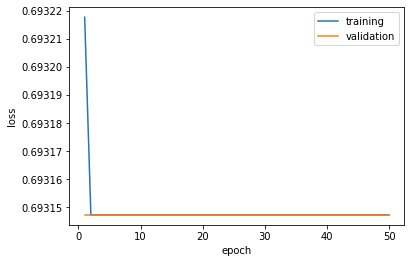

fc1.weight 
 [[-0.00042522  0.03046795 -0.04674582 ...  0.02419115  0.02248169
  -0.00714943]
 [-0.05256627 -0.01476084  0.01372027 ...  0.00203571  0.04231996
   0.00162961]
 [-0.02027166  0.05973462  0.01944802 ... -0.03834351  0.04901766
   0.02382735]
 ...
 [ 0.03603877 -0.02486854 -0.00972376 ... -0.00216061 -0.0051849
   0.0515995 ]
 [ 0.04607052  0.04527395 -0.02967917 ...  0.03281916  0.00893984
   0.00689949]
 [-0.01845303  0.00643366  0.02358667 ... -0.03017515 -0.01964898
   0.03123358]]
fc1.bias 
 [ 0.02592768  0.01472741 -0.03339588 -0.02263921 -0.0436551   0.04901784
  0.03155893 -0.01357437  0.01730591 -0.05013862  0.00615896  0.03703655
 -0.05089536  0.01359677 -0.01088788 -0.01857476 -0.03354496  0.01680246
  0.00597843  0.04411779 -0.05464324 -0.04273502 -0.01156253  0.01242688
  0.02896088 -0.04323313 -0.05714671 -0.00695802  0.01217519 -0.00549499
 -0.00183299  0.01316566  0.03495137 -0.00900456  0.00652294  0.02103885
  0.04867921 -0.03014768 -0.01570873  0.0474254

In [ ]:
#Review training and validation loss

%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

#View the learned weights and biases
for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())

In [ ]:
#Evaluate model performance

#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
import numpy as np

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data
x = torch.Tensor(X_test).float()
_, predicted = torch.max(model(x).data, 1)

# Plot the confusion matrix
cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(cwi_classes))
plt.xticks(tick_marks, cwi_classes, rotation=45)
plt.yticks(tick_marks, cwi_classes)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

ValueError: ignored

In [ ]:
# Save the model weights
model_file = 'models/cwi_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

In [ ]:
#Use the trained model

# New features
x_new = [[50.4,15.3,20,50]]
print ('New sample: {}'.format(x_new))

# Create a new model class and load weights
model = NeuralNet()
model.load_state_dict(torch.load(model_file))

# Set model to evaluation mode
model.eval()

# Get a prediction for the new data sample
x = torch.Tensor(x_new).float()
_, predicted = torch.max(model(x).data, 1)

print('Prediction:',cwi_classes[predicted.item()])